In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from os import chdir 
chdir('C:\\Users\\afeki\\Desktop\\Code\\BootStrapDesicionTree\\')

In [2]:
from gradient_boosting_trees.gradient_boosting_regressor import CartGradientBoostingRegressor, \
    CartGradientBoostingRegressorKfold
from gradient_boosting_trees.gradient_boosting_abstract import GradientBoostingMachine
from Tree.node import Leaf


from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier

# Config

In [3]:
A1 = 2
A2 = 5
SIGMNA = 3
N_ROWS = 10**3
CATEGORICAL_DISTRIBUTION = 'uniform'
CATEGORY_SIZE = 50
CATEGORY_COLUMN_NAME = 'category'
Y_COL_NAME = 'y'
LEFT_GROUP = [i for i in range(CATEGORY_SIZE//2)]
SEED = 3
np.random.seed(SEED)

In [4]:
MAX_DEPTH = 4
N_ESTIMATORS = 100
LEARNING_RATE = 0.1

# Create simulated data
$$ y = a_1 \cdot x_1 + a_2 \cdot I(x_2 \in LEFT\_GROUP) + \sigma $$

$$ x1 - N(0,1) $$

In [5]:
def create_x_y(category_size):
    X = pd.DataFrame()
    X[CATEGORY_COLUMN_NAME] = np.random.randint(0, CATEGORY_SIZE, N_ROWS)
    X['x1'] = np.random.randn(N_ROWS)
    X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].astype('category')
    sigma = SIGMNA*np.random.randn(N_ROWS)
    y = A1*X['x1'] + A2*X[CATEGORY_COLUMN_NAME].isin(LEFT_GROUP) + sigma
    return X,y

# OUR IMPLEMENTATION
## KFOLD

In [6]:
X,y = create_x_y(CATEGORY_SIZE)
kfold_df = X.copy()
kfold_df[Y_COL_NAME] = y
kfold_gbm = CartGradientBoostingRegressorKfold(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
kfold_gbm.fit(kfold_df)
fi = pd.Series(kfold_gbm.compute_feature_importance()).sort_index()
fi/= fi.sum()
fi

category    0.553501
x1          0.446499
dtype: float64

In [7]:
from xgboost.core import Booster
def compute_ntrees_nleaves(gbm):
    total_number_of_trees = 0
    total_number_of_leaves = 0
    if isinstance(gbm,GradientBoostingMachine):
        for tree in gbm.trees:
            if not isinstance(tree.root, Leaf):
                total_number_of_trees += 1
                total_number_of_leaves += tree.n_leaves
    elif isinstance(gbm,GradientBoostingClassifier) or isinstance(gbm,GradientBoostingRegressor):
        total_number_of_trees = gbm.n_estimators_
        for tree in gbm.estimators_:
            total_number_of_leaves += tree[0].get_n_leaves()
    elif isinstance(gbm, Booster):
        df = gbm.trees_to_dataframe()
        total_number_of_leaves = df[df['Feature'] == 'Leaf'].shape[0]
        total_number_of_trees = df[df['Feature'] == 'Leaf']['Tree'].max()

    print(F'number of trees is {total_number_of_trees}')
    print(F'number of leaves is {total_number_of_leaves}')

compute_ntrees_nleaves(kfold_gbm)

number of trees is 15
number of leaves is 66


C:\Users\afeki\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


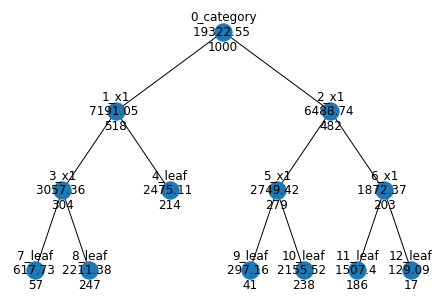

In [8]:
from Tree.tree_visualizer import TreeVisualizer
tree_vis = TreeVisualizer()
tree_vis.plot(kfold_gbm.trees[0].root)

## Vanilla gradient boosting regressor

In [9]:
vanilla_gbm = CartGradientBoostingRegressor(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
vanilla_gbm.fit(kfold_df)
fi = pd.Series(vanilla_gbm.compute_feature_importance()).sort_index()
fi/= fi.sum()
fi

category    0.552213
x1          0.447787
dtype: float64

In [10]:
compute_ntrees_nleaves(vanilla_gbm)

number of trees is 100
number of leaves is 754


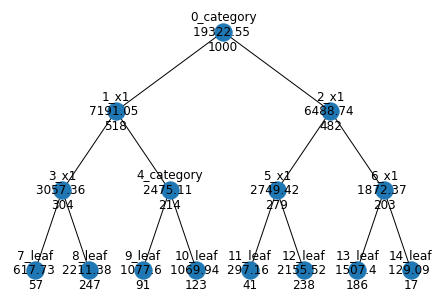

In [11]:
tree_vis = TreeVisualizer()
tree_vis.plot(vanilla_gbm.trees[0].root)

## SKLEARN - One Hot

In [12]:
clf = GradientBoostingRegressor(n_estimators=  N_ESTIMATORS, max_depth = MAX_DEPTH - 1,learning_rate = LEARNING_RATE)
clf.fit(pd.get_dummies(X), y)
fi = pd.Series(clf.feature_importances_, index = pd.get_dummies(X).columns)
print(F"x1 feature importance is: {np.round(fi['x1'],3)}")
compute_ntrees_nleaves(clf)

x1 feature importance is: 0.566
number of trees is 100
number of leaves is 776


## SKLEARN - Mean Imputing

In [13]:
category_to_mean = kfold_df[[CATEGORY_COLUMN_NAME,'y']].groupby(CATEGORY_COLUMN_NAME)['y'].mean().to_dict()
X_m = X.copy()
X_m[CATEGORY_COLUMN_NAME] = X_m[CATEGORY_COLUMN_NAME].map(category_to_mean)
X_m[CATEGORY_COLUMN_NAME].astype('float')
clf = GradientBoostingRegressor(n_estimators=  N_ESTIMATORS, max_depth = MAX_DEPTH - 1,learning_rate = LEARNING_RATE)
clf.fit(X_m, y)
fi =pd.Series(clf.feature_importances_, index = X_m.columns)
print(F"x1 feature importance is: {np.round(fi['x1'],3)}")
compute_ntrees_nleaves(clf)

x1 feature importance is: 0.491
number of trees is 100
number of leaves is 744


## XGBOOST - One Hot

In [14]:
import xgboost as xgb

In [15]:
dtrain = xgb.DMatrix(pd.get_dummies(X), label=y)
param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:linear'}
num_round = N_ESTIMATORS
bst = xgb.train(param, dtrain, num_round)

[18:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


In [16]:
fi = pd.Series(bst.get_score(importance_type='gain'))
fi /= fi.sum()
print(F"x1 feature importance is: {np.round(fi['x1'],3)}")
compute_ntrees_nleaves(bst)

x1 feature importance is: 0.025
number of trees is 99
number of leaves is 762


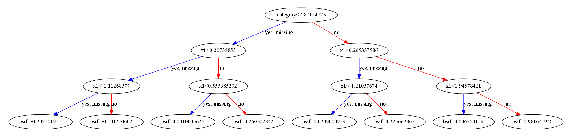

In [23]:
xgb.plot_tree(bst,num_trees= 0)
plt.rcParams['figure.figsize'] = [5, 20]
plt.show()

## XGBOOST - Mean Imputing

In [18]:
X_m[CATEGORY_COLUMN_NAME] = X_m[CATEGORY_COLUMN_NAME].astype('float')
dtrain = xgb.DMatrix(X_m, label=y)
param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:linear'}
num_round = N_ESTIMATORS
bst = xgb.train(param, dtrain, num_round)

[18:43:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


In [19]:
fi = pd.Series(bst.get_score(importance_type='gain'))
fi /= fi.sum()
print(F"x1 feature importance is: {np.round(fi['x1'],3)}")
compute_ntrees_nleaves(bst)

x1 feature importance is: 0.208
number of trees is 99
number of leaves is 684


## Catboost

In [20]:
# !pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [21]:
from catboost import Pool, CatBoostRegressor
# initialize data
# initialize Pool
train_pool = Pool(X, 
                  y, 
                  cat_features=[0])

# specify the training parameters 
model = CatBoostRegressor(iterations=100, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE')
#train the model
model.fit(train_pool)

0:	learn: 4.2297871	total: 64.7ms	remaining: 6.41s
1:	learn: 4.0978215	total: 67.7ms	remaining: 3.32s
2:	learn: 3.9776130	total: 70.9ms	remaining: 2.29s
3:	learn: 3.8806029	total: 73.8ms	remaining: 1.77s
4:	learn: 3.7981203	total: 76.2ms	remaining: 1.45s
5:	learn: 3.7240468	total: 77.6ms	remaining: 1.22s
6:	learn: 3.6488668	total: 79ms	remaining: 1.05s
7:	learn: 3.5982575	total: 80.1ms	remaining: 921ms
8:	learn: 3.5557434	total: 82.8ms	remaining: 837ms
9:	learn: 3.5080297	total: 83.8ms	remaining: 754ms
10:	learn: 3.4688699	total: 84.8ms	remaining: 686ms
11:	learn: 3.4400257	total: 85.8ms	remaining: 630ms
12:	learn: 3.4202865	total: 86.7ms	remaining: 581ms
13:	learn: 3.3989061	total: 87.6ms	remaining: 538ms
14:	learn: 3.3847598	total: 88.4ms	remaining: 501ms
15:	learn: 3.3702119	total: 89.2ms	remaining: 468ms
16:	learn: 3.3569939	total: 90ms	remaining: 439ms
17:	learn: 3.3413643	total: 90.7ms	remaining: 413ms
18:	learn: 3.3292642	total: 91.5ms	remaining: 390ms
19:	learn: 3.3210451	total

In [22]:
print(model.feature_names_)
model.feature_importances_

['category', 'x1']


array([43.87615703, 56.12384297])